In [1]:
import os

# Preview Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Preprocessing Data

import os
import numpy as np
import cv2

# Model Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Accuracy and Loss
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
picture = 'Data'
classes_picture = os.listdir(picture)
print("Classes in this dataset are:")
for i in classes_picture:
    print(i)





Classes in this dataset are:
Adams
Jeremy
Samuel



Adams
Total Images: 101
Resolution of The Image: (1280, 960, 3)


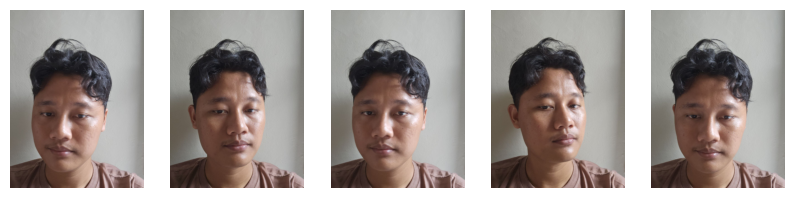


Jeremy
Total Images: 100
Resolution of The Image: (4352, 3264, 3)


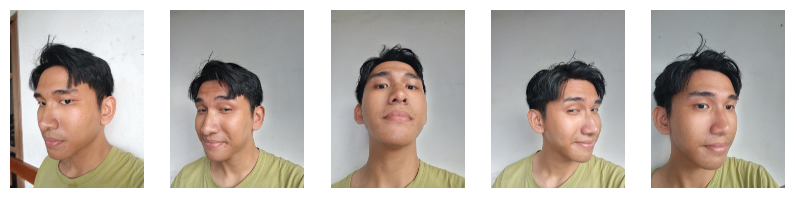


Samuel
Total Images: 101
Resolution of The Image: (4080, 3072, 3)


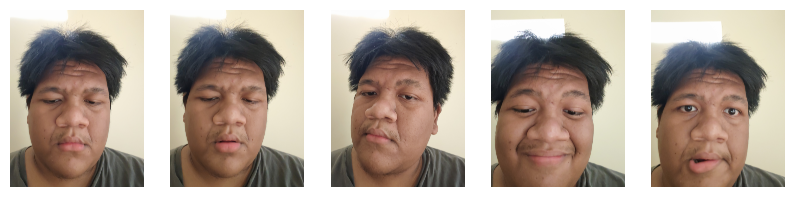

In [4]:
for item in classes_picture:
  print("")
  print(item)
  class_dir = os.path.join(picture, item)
  class_images = os.listdir(class_dir)
  random.shuffle(class_images)

  # Total images in each classes
  num_images = len(class_images)
  print("Total Images:", num_images)

  # Resolution/size of each first image in class
  img_path = os.path.join(class_dir, class_images[0])
  img = mpimg.imread(img_path)
  image_shape = img.shape
  print("Resolution of The Image:", image_shape)

  # Showing some images
  plt.figure(figsize=(10, 5))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

Processing Adams...
Processing Jeremy...
Processing Samuel...

Resized data shape: (302, 224, 224, 3)
Labels shape: (302,)


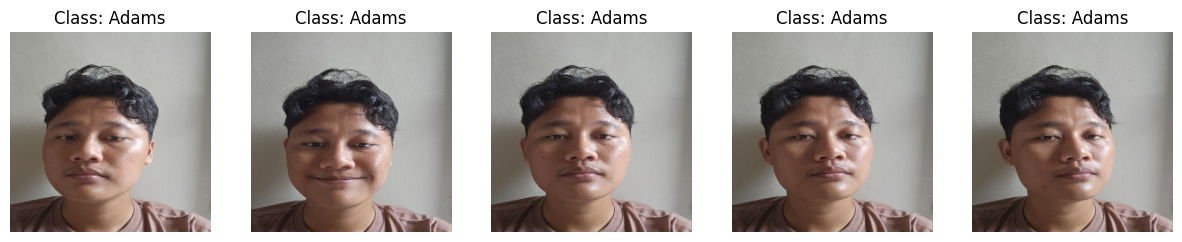

In [5]:
# Define the target size for resizing images
target_size = (224, 224)

# Create lists to store resized images and their labels
X = []  # Images
y = []  # Labels

# Process each class
for class_idx, class_name in enumerate(classes_picture):
    class_dir = os.path.join(picture, class_name)
    class_images = os.listdir(class_dir)
    
    print(f"Processing {class_name}...")
    
    # Process each image in the class
    for img_name in class_images:
        img_path = os.path.join(class_dir, img_name)
        try:
            # Read and resize image
            img = mpimg.imread(img_path)
            img_resized = cv2.resize(img, target_size)
            
            # Append resized image and its label
            X.append(img_resized)
            y.append(class_idx)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print("\nResized data shape:", X.shape)
print("Labels shape:", y.shape)

# Display some resized images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i])
    plt.title(f"Class: {classes_picture[y[i]]}")
    plt.axis('off')
plt.show()


Training set shape: (241, 224, 224, 3)
Testing set shape: (61, 224, 224, 3)


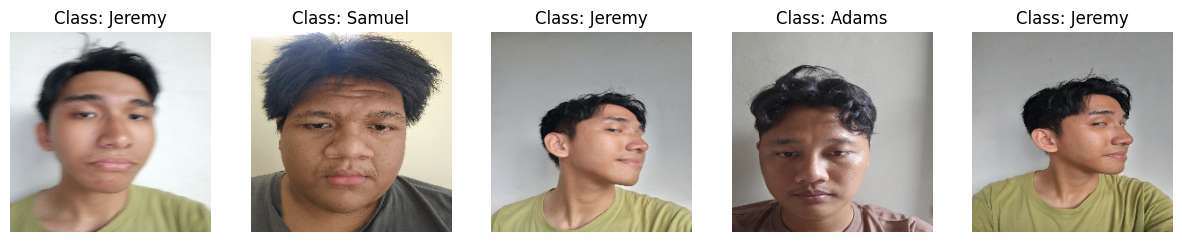

In [6]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Display some training images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Class: {classes_picture[y_train[i]]}")
    plt.axis('off')
plt.show()


In [22]:
# Define data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Create a generator for training data
train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=32
)

# Create a generator for validation data (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(
    X_test,
    y_test,
    batch_size=32,
    shuffle=False
)




In [23]:
model_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in model_base.layers:
    layer.trainable = False


model = tf.keras.Sequential([
    model_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')])

In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,403 (9.27 MB)

 Trainable params: 172,419 (673.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
# Compile the model with Adam optimizer
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Changed from binary_crossentropy
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(X_test) // 32
)


c:\Users\Swift GO 14\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.6508 - loss: 0.7055 - val_accuracy: 0.8125 - val_loss: 0.3941
Epoch 2/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 1.0000 - loss: 0.1871

c:\Users\Swift GO 14\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.1871 - val_accuracy: 0.8125 - val_loss: 0.3787
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 680ms/step - accuracy: 0.9841 - loss: 0.1074 - val_accuracy: 1.0000 - val_loss: 0.0497
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0326 - val_accuracy: 1.0000 - val_loss: 0.0461
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 683ms/step - accuracy: 1.0000 - loss: 0.0203 - val_accuracy: 1.0000 - val_loss: 0.0937
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9375 - val_loss: 0.1068
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 671ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0285
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0185 - val_accuracy: 1.0000 - val_loss: 0.0160
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 732ms/step - accuracy: 0.9982 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 1

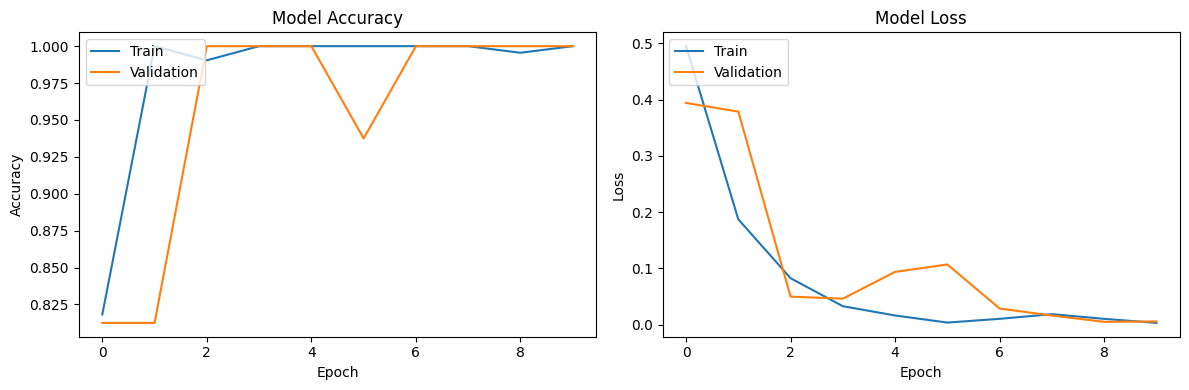

In [26]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 1.0000 - loss: 0.0055
Test accuracy: 1.0000
Test loss: 0.0055
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Number of samples used: 32
True labels shape: (32,)
Predicted classes shape: (32,)


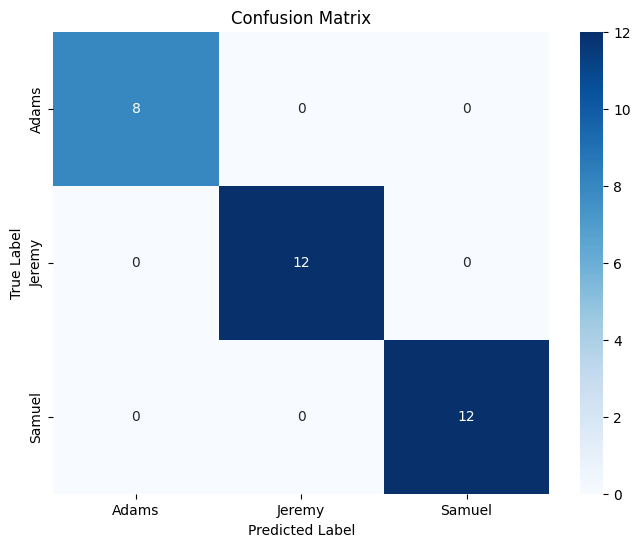


Classification Report:
              precision    recall  f1-score   support

       Adams       1.00      1.00      1.00         8
      Jeremy       1.00      1.00      1.00        12
      Samuel       1.00      1.00      1.00        12

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [27]:
# Reset the generator before evaluation
val_generator.reset()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(val_generator, steps=len(X_test) // 32)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Reset generator again for predictions
val_generator.reset()

# Get predictions
predictions = model.predict(val_generator, steps=len(X_test) // 32)
predicted_classes = np.argmax(predictions, axis=1)

# Use the original test labels instead of extracting from generator
# Calculate how many samples were actually used in predictions
num_samples_used = len(predicted_classes)
true_labels = y_test[:num_samples_used]

print(f"Number of samples used: {num_samples_used}")
print(f"True labels shape: {true_labels.shape}")
print(f"Predicted classes shape: {predicted_classes.shape}")

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Adams', 'Jeremy', 'Samuel'],
            yticklabels=['Adams', 'Jeremy', 'Samuel'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, 
                          target_names=['Adams', 'Jeremy', 'Samuel']))


In [28]:
model.save('model.h5')